In [406]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

#import plotly for visualization
import plotly.offline as pyoff
import plotly.graph_objs as go

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [407]:
pyoff.init_notebook_mode()


In [456]:
df3 = pd.read_excel('Online Retail.xlsx')


In [466]:
df2=df3.copy()

In [467]:
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

In [468]:
df2.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [469]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [470]:
df2_3m = df2[(df2.InvoiceDate < date(2011,6,1)) & (df2.InvoiceDate >= date(2011,1,1))].reset_index(drop=True)
df2_6m = df2[(df2.InvoiceDate >= date(2011,6,1)) & (df2.InvoiceDate < date(2011,12,1))].reset_index(drop=True)


In [471]:
df2_user = pd.DataFrame(df2_3m['CustomerID'].unique())
df2_user.columns = ['CustomerID']
def user_cluster(cluster_field_name,target_field_name,df,ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']],on = cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
df2_Recency = df2_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
df2_Recency.columns=['CustomerID','MaxPurchaseDate']
df2_Recency['Recency'] = (df2_Recency['MaxPurchaseDate'].max()-df2_Recency['MaxPurchaseDate']).dt.days
df2_user = pd.merge(df2_user,df2_Recency[['CustomerID','Recency']],on='CustomerID')
kmeans = KMeans(n_clusters=4)
kmeans.fit(df2_user[['Recency']])
df2_user['RecencyCluster']=kmeans.predict(df2_user[['Recency']])
df2_user = user_cluster('RecencyCluster', 'Recency',df2_user,False)
df2_Frequency = df2_3m.groupby('CustomerID').InvoiceDate.nunique().reset_index()
df2_Frequency.columns=['CustomerID','Frequency']
df2_user = pd.merge(df2_user,df2_Frequency,on='CustomerID')
kmeans = KMeans(n_clusters=4)
kmeans.fit(df2_user[['Frequency']])
df2_user['FrequencyCluster']=kmeans.predict(df2_user[['Frequency']])
df2_user = user_cluster('FrequencyCluster', 'Frequency',df2_user,True)
#calcuate revenue score
df2_3m['Monetary'] = df2_3m['UnitPrice'] * df2_3m['Quantity']
df2_Monetary = df2_3m.groupby('CustomerID').Monetary.sum().reset_index()
df2_user = pd.merge(df2_user, df2_Monetary, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(df2_user[['Monetary']])
df2_user['MonetaryCluster'] = kmeans.predict(df2_user[['Monetary']])
df2_user = user_cluster('MonetaryCluster', 'Monetary',df2_user,True)
df2_user['OverallScore'] = df2_user['RecencyCluster'] + df2_user['FrequencyCluster'] + df2_user['MonetaryCluster']
df2_user['Segment'] = 'Low-Value'
df2_user.loc[df2_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df2_user.loc[df2_user['OverallScore']>4,'Segment'] = 'High-Value' 
df2_6m['Revenue'] = df2_6m['UnitPrice'] * df2_6m['Quantity']
df2_6m = df2_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
df2_6m.columns = ['CustomerID','m6_Revenue']

In [472]:
plot_data = [
    go.Histogram(
        x=df2_6m.query('m6_Revenue < 10000')['m6_Revenue']
 )
]

plot_layout = go.Layout(
        title='6m Revenue'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [473]:
df2_merge = pd.merge(df2_user, df2_6m, on='CustomerID', how='left')
df2_graph = df2_merge.query("m6_Revenue < 30000")
plot_data = [
    go.Scatter(
        x=df2_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=df2_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
 )
 ),
        go.Scatter(
        x=df2_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=df2_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
 )
 ),
        go.Scatter(
        x=df2_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=df2_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
 )
 ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [474]:
#remove outliers
df2_merge = df2_merge[df2_merge['m6_Revenue']<df2_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df2_merge[['m6_Revenue']])
df2_merge['LTVCluster'] = kmeans.predict(df2_merge[['m6_Revenue']])

#order cluster number based on LTV
df2_merge = order_cluster('LTVCluster', 'm6_Revenue',df2_merge,True)

#creatinga new cluster dataframe
df2_cluster = df2_merge.copy()

#see details of the clusters
df2_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

count          mean          std       min        25%       50%  \
LTVCluster                                                                     
0           1523.0    826.265011   638.091544   -609.40    316.840    643.55   
1            227.0   4318.615639  1588.390599   2583.15   3073.935   3781.26   
2             23.0  14819.104348  3586.408659  10062.85  11861.385  13636.42   

                  75%       max  
LTVCluster                       
0            1235.230   2571.86  
1            5176.540   9455.48  
2           18247.105  20917.63

In [475]:
#convert categorical columns to numerical
df2_class = pd.get_dummies(df2_cluster)
df2_class.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Monetary  \
0     13313.0       23               3          2                 0    609.74   
1     18097.0       13               3          2                 0   1274.04   
2     15164.0       16               3          2                 0    368.18   
3     14732.0       28               3          3                 0    980.48   
4     14221.0       14               3          2                 0    863.98   

   MonetaryCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0                0             3      945.58           0                   0   
1                0             3      549.89           0                   0   
2                0             3      474.87           0                   0   
3                0             3     1241.75           0                   0   
4                0             3     2563.87           0                   0   

   Segment_Low-Value  Segment_Mid-Value  
0                  0                  1  
1                  0                  1  
2                  0                  1  
3                  0                  1  
4                  0                  1

In [476]:
#calculate and show correlations
corr_matrix = df2_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = df2_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = df2_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [477]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=6, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
 .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
 .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))


Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.87


In [478]:
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        80
           1       0.36      0.50      0.42         8
           2       0.00      0.00      0.00         1

    accuracy                           0.87        89
   macro avg       0.44      0.47      0.45        89
weighted avg       0.88      0.87      0.87        89



In [409]:
df1=df3.copy()

In [410]:
df1['InvoiceDate']= pd.to_datetime(df1['InvoiceDate'])
df1_9m =df1[(df1.InvoiceDate < date(2011,9,1)) & (df1.InvoiceDate >= date(2011,1,1))].reset_index(drop=True)
df1_next = df1[(df1.InvoiceDate >= date(2011,9,1)) & (df1.InvoiceDate < date(2011,12,1))].reset_index(drop=True)
df1_user = pd.DataFrame(df1_9m['CustomerID'].unique())
df1_user.columns = ['CustomerID'] 

In [411]:
df1_next_first_buy = df1_next.groupby('CustomerID').InvoiceDate.min().reset_index()
df1_next_first_buy.columns = ['CustomerID','MinPurchaseDate']
df1_last_buy = df1_9m.groupby('CustomerID').InvoiceDate.max().reset_index()
df1_last_buy.columns = ['CustomerID','MaxPurchaseDate']

In [412]:
df1_purchase_dates = pd.merge(df1_last_buy,df1_next_first_buy,on='CustomerID',how='left')
df1_purchase_dates

CustomerID     MaxPurchaseDate     MinPurchaseDate
0        12346.0 2011-01-18 10:17:00                 NaT
1        12347.0 2011-08-02 08:48:00 2011-10-31 12:25:00
2        12348.0 2011-04-05 10:47:00 2011-09-25 13:13:00
3        12350.0 2011-02-02 16:01:00                 NaT
4        12352.0 2011-03-22 16:08:00 2011-09-20 14:34:00
...          ...                 ...                 ...
3149     18280.0 2011-03-07 09:52:00                 NaT
3150     18281.0 2011-06-12 10:53:00                 NaT
3151     18282.0 2011-08-09 15:10:00                 NaT
3152     18283.0 2011-07-14 13:20:00 2011-09-05 12:35:00
3153     18287.0 2011-05-22 10:39:00 2011-10-12 10:23:00

[3154 rows x 3 columns]

In [413]:
df1_purchase_dates['NextPurchaseDay']=(df1_purchase_dates['MinPurchaseDate']-df1_purchase_dates['MaxPurchaseDate']).dt.days
df1_user = pd.merge(df1_user, df1_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')
df1_user

CustomerID  NextPurchaseDay
0        13313.0            105.0
1            NaN              NaN
2        18097.0              NaN
3        16656.0             20.0
4        16875.0             73.0
...          ...              ...
3150     16083.0              NaN
3151     13726.0             61.0
3152     15690.0              NaN
3153     17777.0             60.0
3154     16278.0              5.0

[3155 rows x 2 columns]

In [414]:
df1_user = df1_user.fillna(999)


In [415]:
df1_max_purchase = df1_9m.groupby('CustomerID').InvoiceDate.max().reset_index()
df1_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
#因為實際做的時候時間早就已經超過數據內最後購買期間，所以用整個數據中日期最晚的那天做為最後一天，然後用這天減去每一個消費者最後購買的天數
#即可得知R的區間在哪，越短代表越接近購買
df1_max_purchase['Recency'] = (df1_max_purchase['MaxPurchaseDate'].max() - df1_max_purchase['MaxPurchaseDate']).dt.days
df1_user = pd.merge(df1_user, df1_max_purchase[['CustomerID','Recency']], on='CustomerID')
plot_data=[go.Histogram(x=df1_user['Recency'])]
plot_layout=go.Layout(title='Recency')
fig=go.Figure(data=plot_data,layout=plot_layout)
pyoff.iplot(fig)


In [416]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df1_user[['Recency']])
df1_user['RecencyCluster']=kmeans.predict(df1_user[['Recency']])

In [417]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df1_user=order_cluster('RecencyCluster','Recency',df1_user,False)

In [418]:
df1_frequency = df1_9m.groupby('CustomerID').InvoiceDate.nunique().reset_index()
df1_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
df1_user = pd.merge(df1_user, df1_frequency, on='CustomerID')
kmeans = KMeans(n_clusters=4)
kmeans.fit(df1_user[['Frequency']])
df1_user['FrequencyCluster'] = kmeans.predict(df1_user[['Frequency']])
df1_user = order_cluster('FrequencyCluster', 'Frequency',df1_user,True)
plot_data = [
    go.Histogram(
        x=df1_user.query('Frequency < 120')['Frequency']
 )
]

plot_layout = go.Layout(
        title='Frequency'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [419]:
df1['Money']=df1['UnitPrice']*df1['Quantity']
df1_moeny = df1.groupby('CustomerID').Money.sum().reset_index()
df1_user = pd.merge(df1_user, df1_moeny, on='CustomerID')


In [420]:
df1_user

CustomerID  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0        13313.0            105.0       40               3          3   
1        18097.0            999.0        0               3          5   
2        14210.0             14.0        5               3          5   
3        13397.0             37.0       10               3          5   
4        17457.0            999.0       26               3          5   
...          ...              ...      ...             ...        ...   
3149     17841.0              3.0        3               3         98   
3150     15311.0             13.0       12               3         70   
3151     13089.0              0.0        0               3         77   
3152     14911.0              2.0        1               3        115   
3153     12748.0              2.0        1               3         98   

      FrequencyCluster      Money  
0                    0    1555.32  
1                    0    2692.85  
2                    0    1900.89  
3                    0    1539.18  
4                    0    1737.70  
...                ...        ...  
3149                 3   40340.78  
3150                 3   59419.34  
3151                 3   57385.88  
3152                 3  132572.62  
3153                 3   29072.10  

[3154 rows x 7 columns]

In [421]:
plot_data = [
    go.Histogram(
        x=df1_user.query('Money < 10000')['Money']
 )
]

plot_layout = go.Layout(
        title='Monetary Value'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [422]:
kmeans_M= KMeans(n_clusters=4)
kmeans_M.fit(df1_user[['Money']])
df1_user['MoneyCluster']=kmeans_M.predict(df1_user[['Money']])
df1_user = order_cluster('MoneyCluster','Money',df1_user,True)
df1_user.groupby('MoneyCluster')['Money'].describe()


count           mean           std        min          25%  \
MoneyCluster                                                                
0             3114.0    1665.392910   2282.274069   -4287.63     353.9175   
1               33.0   37238.807273  14403.896372   19786.44   26763.3400   
2                5.0  129057.952000  36658.292209   88125.38  113384.1400   
3                2.0  267963.755000  16299.186073  256438.49  262201.1225   

                     50%          75%        max  
MoneyCluster                                      
0                865.955    2010.9775   18793.41  
1              33350.760   50992.6100   65892.08  
2             123725.450  132572.6200  187482.17  
3             267963.755  273726.3875  279489.02

In [423]:
df1_user['OverallScore']=df1_user['RecencyCluster']+df1_user['FrequencyCluster']+df1_user['MoneyCluster']
df1_user['Segment'] = 'Low-Value'
df1_user.loc[df1_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df1_user.loc[df1_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [424]:
df1_graph = df1_user.query("Money < 50000 and Frequency < 150")

In [425]:
df1_day_order = df_9m[['CustomerID','InvoiceDate']]
df1_day_order['InvoiceDay'] = df_9m['InvoiceDate'].dt.date
df1_day_order = df1_day_order.sort_values(['CustomerID','InvoiceDate'])
df1_day_order = df1_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')


In [426]:
df1_day_order['PrevInvoiceDate'] = df1_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
df1_day_order['T2InvoiceDate'] = df1_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
df1_day_order['T3InvoiceDate'] = df1_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)


In [427]:
df1_day_order.head()

CustomerID         InvoiceDate  InvoiceDay PrevInvoiceDate  \
42950      12347.0 2011-04-07 10:43:00  2011-04-07             NaN   
115237     12347.0 2011-06-09 13:01:00  2011-06-09      2011-04-07   
181286     12347.0 2011-08-02 08:48:00  2011-08-02      2011-06-09   
40678      12348.0 2011-04-05 10:47:00  2011-04-05             NaN   
974        12352.0 2011-03-01 14:57:00  2011-03-01             NaN   

       T2InvoiceDate T3InvoiceDate  
42950            NaN           NaN  
115237           NaN           NaN  
181286    2011-04-07           NaN  
40678            NaN           NaN  
974              NaN           NaN

In [428]:
df1_day_order['DayDiff'] = (df1_day_order['InvoiceDay'] - df1_day_order['PrevInvoiceDate']).dt.days
df1_day_order['DayDiff2'] = (df1_day_order['InvoiceDay'] - df1_day_order['T2InvoiceDate']).dt.days
df1_day_order['DayDiff3'] = (df1_day_order['InvoiceDay'] - df1_day_order['T3InvoiceDate']).dt.days

In [429]:
df1_day_diff = df1_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
df1_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [430]:
df1_day_order_last = df1_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [431]:
df1_day_order_last

CustomerID         InvoiceDate  InvoiceDay PrevInvoiceDate  \
181286     12347.0 2011-08-02 08:48:00  2011-08-02      2011-06-09   
40678      12348.0 2011-04-05 10:47:00  2011-04-05             NaN   
24402      12352.0 2011-03-22 16:07:00  2011-03-22      2011-03-17   
92036      12353.0 2011-05-19 17:47:00  2011-05-19             NaN   
60932      12354.0 2011-04-21 13:11:00  2011-04-21             NaN   
...            ...                 ...         ...             ...   
117619     18281.0 2011-06-12 10:53:00  2011-06-12             NaN   
190351     18282.0 2011-08-09 15:10:00  2011-08-09      2011-08-05   
158298     18283.0 2011-07-14 13:00:00  2011-07-14      2011-06-23   
93381      18287.0 2011-05-22 10:39:00  2011-05-22             NaN   
214186         NaN 2011-08-31 09:23:00  2011-08-31             NaN   

       T2InvoiceDate T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  
181286    2011-04-07           NaN     54.0     117.0       NaN  
40678            NaN           NaN      NaN       NaN       NaN  
24402     2011-03-01           NaN      5.0      21.0       NaN  
92036            NaN           NaN      NaN       NaN       NaN  
60932            NaN           NaN      NaN       NaN       NaN  
...              ...           ...      ...       ...       ...  
117619           NaN           NaN      NaN       NaN       NaN  
190351           NaN           NaN      4.0       NaN       NaN  
158298    2011-06-14    2011-05-23     21.0      30.0      52.0  
93381            NaN           NaN      NaN       NaN       NaN  
214186           NaN           NaN      NaN       NaN       NaN  

[2846 rows x 9 columns]

In [432]:
df1_day_order_last = df1_day_order_last.dropna()
df1_day_order_last = pd.merge(df1_day_order_last, df1_day_diff, on='CustomerID')
df1_user = pd.merge(df1_user, df1_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')


In [433]:
df1_class = df1_user.copy()

In [434]:
df1_class

CustomerID  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0       13225.0             82.0       43               3          5   
1       12484.0             33.0        0               3          5   
2       13593.0            999.0        8               3          5   
3       17629.0             53.0       20               3          5   
4       15727.0             90.0        7               3          5   
..          ...              ...      ...             ...        ...   
687     17450.0              1.0        0               3         24   
688     14156.0             17.0       14               3         36   
689     14911.0              2.0        1               3        115   
690     14646.0              7.0        0               3         42   
691     18102.0             27.0       26               3         22   

     FrequencyCluster      Money  MoneyCluster  OverallScore     Segment  \
0                   0    6083.04             0             3   Mid-Value   
1                   0    4495.27             0             3   Mid-Value   
2                   0    1990.28             0             3   Mid-Value   
3                   0    1784.12             0             3   Mid-Value   
4                   0    5178.96             0             3   Mid-Value   
..                ...        ...           ...           ...         ...   
687                 2  187482.17             2             7  High-Value   
688                 2  113384.14             2             7  High-Value   
689                 3  132572.62             2             8  High-Value   
690                 2  279489.02             3             8  High-Value   
691                 2  256438.49             3             8  High-Value   

     DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0       53.0     110.0     127.0    42.333333   22.030282  
1        3.0      76.0     177.0    59.000000   50.477718  
2       54.0     155.0     156.0    52.000000   50.029991  
3       51.0      94.0     130.0    43.333333    7.505553  
4       36.0      91.0     141.0    47.000000    9.848858  
..       ...       ...       ...          ...         ...  
687      8.0      14.0      34.0    11.666667    8.820971  
688      2.0       7.0      12.0     8.047619    5.731284  
689      4.0       7.0       9.0     2.712121    2.441722  
690      5.0       8.0      13.0     7.571429    7.221990  
691      8.0      16.0      32.0    12.916667    9.718383  

[692 rows x 15 columns]

In [435]:
df1_class

CustomerID  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0       13225.0             82.0       43               3          5   
1       12484.0             33.0        0               3          5   
2       13593.0            999.0        8               3          5   
3       17629.0             53.0       20               3          5   
4       15727.0             90.0        7               3          5   
..          ...              ...      ...             ...        ...   
687     17450.0              1.0        0               3         24   
688     14156.0             17.0       14               3         36   
689     14911.0              2.0        1               3        115   
690     14646.0              7.0        0               3         42   
691     18102.0             27.0       26               3         22   

     FrequencyCluster      Money  MoneyCluster  OverallScore     Segment  \
0                   0    6083.04             0             3   Mid-Value   
1                   0    4495.27             0             3   Mid-Value   
2                   0    1990.28             0             3   Mid-Value   
3                   0    1784.12             0             3   Mid-Value   
4                   0    5178.96             0             3   Mid-Value   
..                ...        ...           ...           ...         ...   
687                 2  187482.17             2             7  High-Value   
688                 2  113384.14             2             7  High-Value   
689                 3  132572.62             2             8  High-Value   
690                 2  279489.02             3             8  High-Value   
691                 2  256438.49             3             8  High-Value   

     DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0       53.0     110.0     127.0    42.333333   22.030282  
1        3.0      76.0     177.0    59.000000   50.477718  
2       54.0     155.0     156.0    52.000000   50.029991  
3       51.0      94.0     130.0    43.333333    7.505553  
4       36.0      91.0     141.0    47.000000    9.848858  
..       ...       ...       ...          ...         ...  
687      8.0      14.0      34.0    11.666667    8.820971  
688      2.0       7.0      12.0     8.047619    5.731284  
689      4.0       7.0       9.0     2.712121    2.441722  
690      5.0       8.0      13.0     7.571429    7.221990  
691      8.0      16.0      32.0    12.916667    9.718383  

[692 rows x 15 columns]

In [436]:
df1_class=pd.get_dummies(df1_class)

In [437]:
df1_class

CustomerID  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0       13225.0             82.0       43               3          5   
1       12484.0             33.0        0               3          5   
2       13593.0            999.0        8               3          5   
3       17629.0             53.0       20               3          5   
4       15727.0             90.0        7               3          5   
..          ...              ...      ...             ...        ...   
687     17450.0              1.0        0               3         24   
688     14156.0             17.0       14               3         36   
689     14911.0              2.0        1               3        115   
690     14646.0              7.0        0               3         42   
691     18102.0             27.0       26               3         22   

     FrequencyCluster      Money  MoneyCluster  OverallScore  DayDiff  \
0                   0    6083.04             0             3     53.0   
1                   0    4495.27             0             3      3.0   
2                   0    1990.28             0             3     54.0   
3                   0    1784.12             0             3     51.0   
4                   0    5178.96             0             3     36.0   
..                ...        ...           ...           ...      ...   
687                 2  187482.17             2             7      8.0   
688                 2  113384.14             2             7      2.0   
689                 3  132572.62             2             8      4.0   
690                 2  279489.02             3             8      5.0   
691                 2  256438.49             3             8      8.0   

     DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  Segment_High-Value  \
0       110.0     127.0    42.333333   22.030282                   0   
1        76.0     177.0    59.000000   50.477718                   0   
2       155.0     156.0    52.000000   50.029991                   0   
3        94.0     130.0    43.333333    7.505553                   0   
4        91.0     141.0    47.000000    9.848858                   0   
..        ...       ...          ...         ...                 ...   
687      14.0      34.0    11.666667    8.820971                   1   
688       7.0      12.0     8.047619    5.731284                   1   
689       7.0       9.0     2.712121    2.441722                   1   
690       8.0      13.0     7.571429    7.221990                   1   
691      16.0      32.0    12.916667    9.718383                   1   

     Segment_Low-Value  Segment_Mid-Value  
0                    0                  1  
1                    0                  1  
2                    0                  1  
3                    0                  1  
4                    0                  1  
..                 ...                ...  
687                  0                  0  
688                  0                  0  
689                  0                  0  
690                  0                  0  
691                  0                  0  

[692 rows x 17 columns]

In [438]:
df1_class['NextPurchaseDayRange'] = 2
df1_class.loc[df1_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
df1_class.loc[df1_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

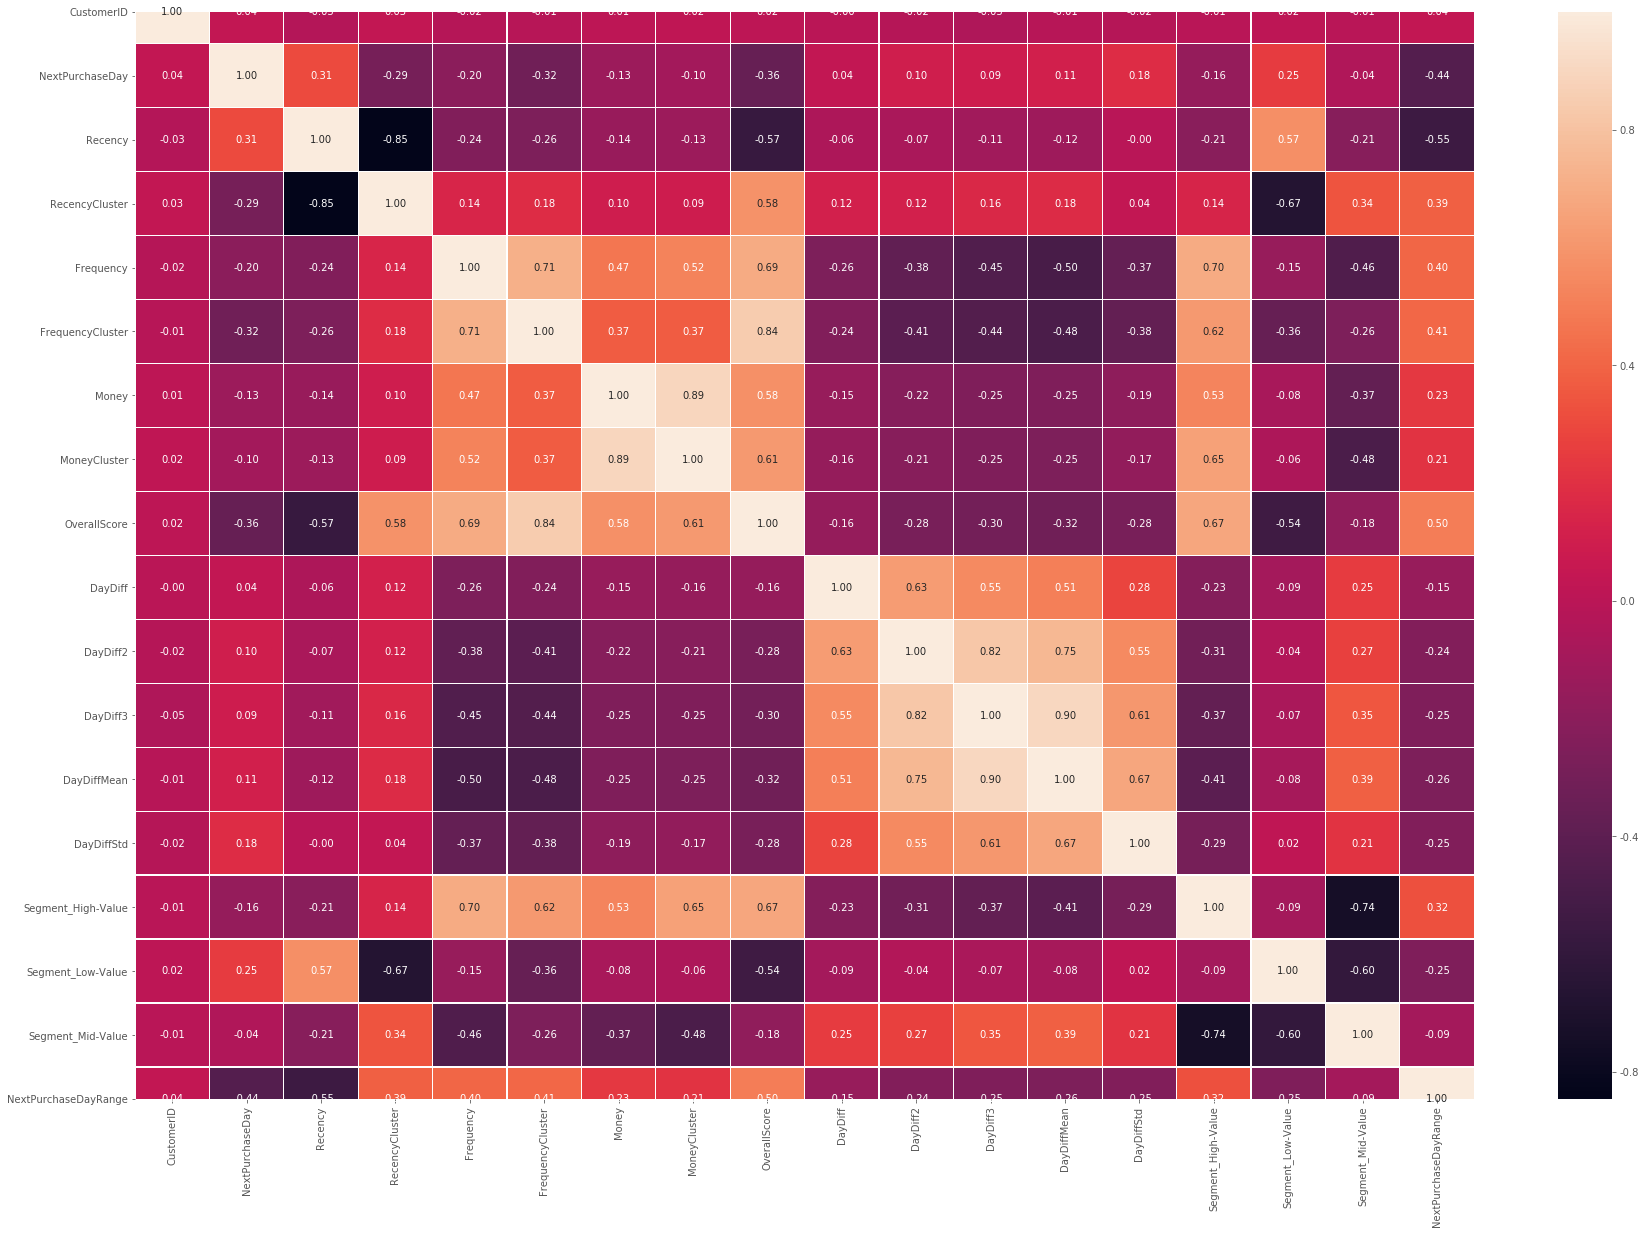

In [439]:
corr = df1_class[df1_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [440]:
df1_class = df1_class.drop('NextPurchaseDay',axis=1)
X= df1_class.drop('NextPurchaseDayRange',axis=1)
y=df1_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)


In [441]:
from sklearn.ensemble import GradientBoostingClassifier
#create an array of models

models.append(("GBDT",GradientBoostingClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")


In [443]:
print(name, cv_result)

GBDT [0.73469388 0.69387755 0.63265306 0.55102041 0.60416667 0.70833333
 0.58333333 0.64583333 0.64583333 0.72916667]


In [444]:
GBDT_model = GradientBoostingClassifier().fit(X_train, y_train)
print('Accuracy of GBDT classifier on training set: {:.2f}'
 .format(GBDT_model.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
 .format(GBDT_model.score(X_test[X_train.columns], y_test)))

Accuracy of GBDT classifier on training set: 0.99
Accuracy of GBDT classifier on test set: 0.58


In [448]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_samples_leaf':range(2,20,2),
 'max_features':range(3,10,1),
'n_estimators':range(100,200,10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5,
  'max_features': 6,
  'min_samples_leaf': 18,
  'n_estimators': 140},
 0.6879685125420487)

In [450]:
!pip install lifetimes

In [455]:
plt.style.use('ggplot')
from lifetimes.utils import summary_data_from_transaction_data
import lifetimes

In [490]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [480]:
df9 = df3.copy()

In [481]:
df9.head(2).T

0                    1
InvoiceNo                                536365               536365
StockCode                                85123A                71053
Description  WHITE HANGING HEART T-LIGHT HOLDER  WHITE METAL LANTERN
Quantity                                      6                    6
InvoiceDate                 2010-12-01 08:26:00  2010-12-01 08:26:00
UnitPrice                                  2.55                 3.39
CustomerID                                17850                17850
Country                          United Kingdom       United Kingdom

In [482]:
df9.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [483]:
(df9[df9.InvoiceNo.map(lambda x:str(x)[0] == 'C')].Quantity > 0).any()


False

In [486]:
print(df9.InvoiceNo.map(lambda x:str(x)[0] == 'C').value_counts())
print(df[df.InvoiceNo.map(lambda x:str(x)[0] != 'C')].query('Quantity < 0'))

False    532621
True       9288
Name: InvoiceNo, dtype: int64
       InvoiceNo StockCode Description  Quantity         InvoiceDate  \
2406      536589     21777         NaN       -10 2010-12-01 16:50:00   
4347      536764    84952C         NaN       -38 2010-12-02 14:42:00   
7188      536996     22712         NaN       -20 2010-12-03 15:30:00   
7189      536997     22028         NaN       -20 2010-12-03 15:30:00   
7190      536998     85067         NaN        -6 2010-12-03 15:30:00   
...          ...       ...         ...       ...                 ...   
535333    581210     23395       check       -26 2011-12-07 18:36:00   
535335    581212     22578        lost     -1050 2011-12-07 18:38:00   
535336    581213     22576       check       -30 2011-12-07 18:38:00   
536908    581226     23090     missing      -338 2011-12-08 09:56:00   
538919    581422     23169     smashed      -235 2011-12-08 15:24:00   

        UnitPrice  CustomerID         Country  
2406          0.0        

In [487]:
df9.isna().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [488]:
df9.dropna(inplace=True)

In [493]:
df9['Sales'] = df9.Quantity*df9.UnitPrice


In [517]:
df9 = df9[(df9.Sales > 0)].reset_index(drop=True)

In [518]:
df9 = df9[['InvoiceNo', 'CustomerID', 'InvoiceDate', 'Sales']]

### 更改用戶ID類型
df9.CustomerID = df9.CustomerID.astype('object')

df9.nunique()

InvoiceNo      19960
CustomerID      4338
InvoiceDate    18499
Sales           4906
dtype: int64

In [519]:
df9.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [520]:
data = summary_data_from_transaction_data(df9, 'CustomerID', 'InvoiceDate',
                         monetary_value_col='Sales',
                         observation_period_end='2011-12-9')
data.sort_values('monetary_value').head()

frequency  recency      T  monetary_value
CustomerID                                           
12346.0           0.0      0.0  325.0             0.0
15130.0           0.0      0.0  169.0             0.0
15127.0           0.0      0.0   65.0             0.0
17852.0           0.0      0.0   11.0             0.0
15120.0           0.0      0.0  133.0             0.0

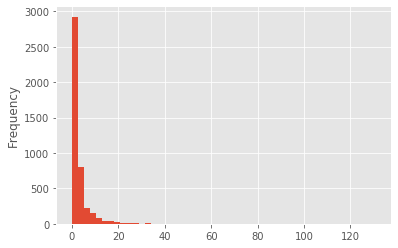

In [521]:
data['frequency'].plot(kind='hist', bins=50)


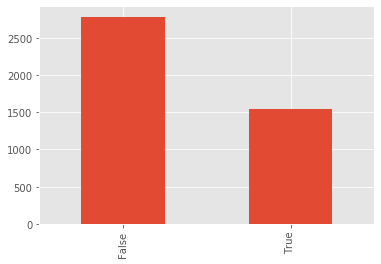

In [522]:
(data.frequency == 0).value_counts().plot.bar()


In [523]:
sum(data['frequency'] == 0)/float(len(data))


0.35684647302904565

In [524]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>


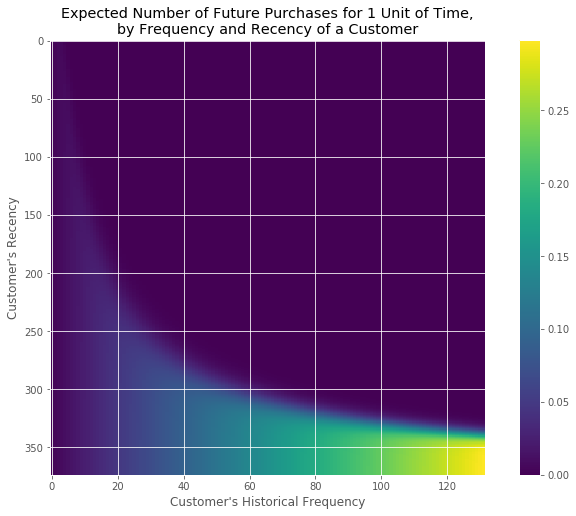

In [525]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

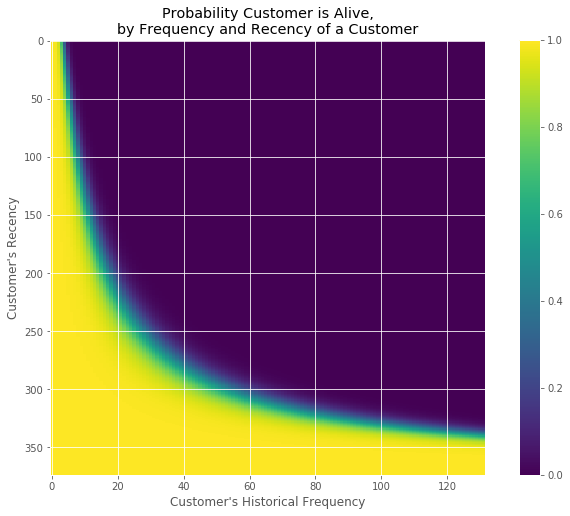

In [526]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [527]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                  data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases', ascending=False).head()

frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
14911.0         131.0    372.0  373.0     1093.661679             0.298303
12748.0         112.0    373.0  373.0      301.024821             0.255310
17841.0         111.0    372.0  373.0      364.452162             0.253045
15311.0          89.0    373.0  373.0      677.729438             0.203263
14606.0          88.0    372.0  373.0      135.890114             0.200998

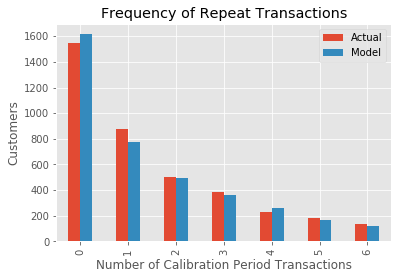

In [528]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [529]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
summary_cal_holdout.head()

frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                184.0  
12347.0                184.0  
12348.0                184.0  
12350.0                184.0  
12352.0                184.0

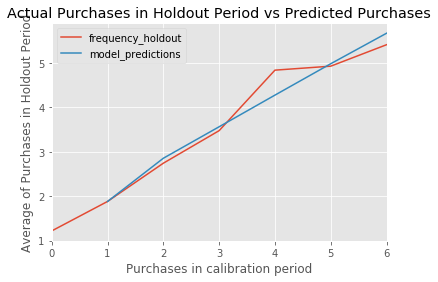

In [530]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [507]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.16193929281455013

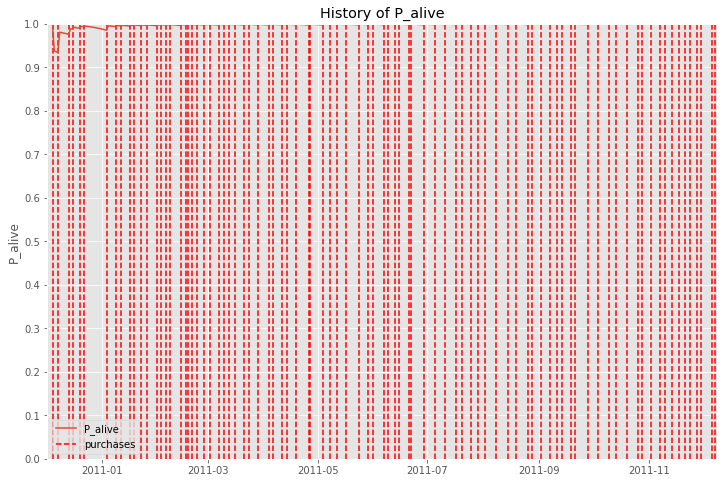

In [531]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

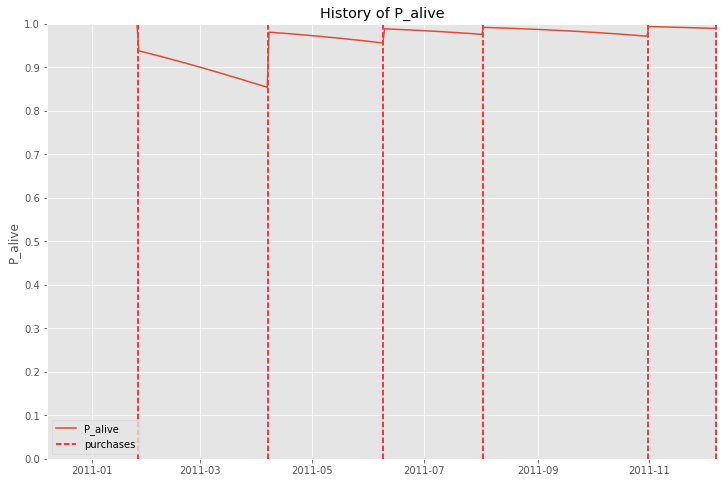

In [532]:
fig = plt.figure(figsize=(12,8))
id = 12347
days_since_birth = 365
sp_trans = df.query('CustomerID == @id')
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [533]:
returning_customers_summary = data[data['frequency']>0]
returning_customers_summary.shape[0]

# 模型訓練
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>

In [535]:
ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    )

CustomerID
12346.0    416.946028
12347.0    569.978836
12348.0    333.784235
12349.0    416.946028
12350.0    416.946028
              ...    
18280.0    416.946028
18281.0    416.946028
18282.0    260.340479
18283.0    174.532812
18287.0    492.169257
Length: 4338, dtype: float64